In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pprint
import sncosmo

In [3]:
print (sncosmo.__file__)

/Users/rbiswas/.local/lib/python2.7/site-packages/sncosmo-1.3.dev601-py2.7-macosx-10.5-x86_64.egg/sncosmo/__init__.pyc


In [4]:
from lsst.sims.photUtils import Bandpass
from lsst.sims.photUtils import BandpassDict

In [5]:
from lsst.sims.catUtils.supernovae import SNObject
from lsst.sims.catUtils.supernovae import settwopanel

# Load some stuff not directly connected to SNObject

#### LSST BandpassDicts

These are imported from `lsst.sims.photUtils.BandPassDict` and form an ordered dict of BandPass Instances for names.

In [6]:
bandpassnames = ['u', 'g', 'r', 'i', 'z', 'y']
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()

These bandpasses will be used as examples to obtain fluxes, and magnitudes. Also bandpass instances have an attribute `wavelen`, which are useful grids to obtain SEDs on. However, note that the grid is really too fine in comparison to the grid for SN models and will only serve to slow down flux calculations without helping accuracy. 

In [7]:
bpwavelengrid = LSST_BandPass['u'].wavelen
print(bpwavelengrid)

[  300.    300.1   300.2 ...,  1149.8  1149.9  1150. ]


In [8]:
BP, HBP = BandpassDict.loadBandpassesFromFiles()

In [9]:
def plotBandPasses(bandpassDict, logscale=False, ax=None, fig=None,
                   label=None, **kwargs):
    if fig is None:
        fig, ax = plt.subplots()
    ax.plot(bandpassDict['u'].wavelen, bandpassDict['u'].sb, label=label, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['g'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['r'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['i'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['z'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['y'].sb, **kwargs)
    if logscale:
        ax.set_yscale('log')
    ax.set_ylim(ymin=1.0e-6)
    return fig

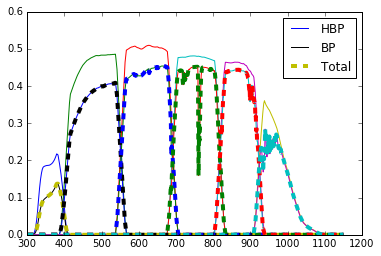

In [10]:
lstyle = dict()
lstyle['linestyle'] = '--'
lstyle['lw'] = 4.
fig = plotBandPasses(HBP, label='HBP')
fig = plotBandPasses(BP, fig=fig, ax=fig.axes[0], label='BP')
fig = plotBandPasses(LSST_BandPass, fig=fig, ax=fig.axes[0], label='Total',**lstyle)
plt.legend(loc='best')

# The SNObject

The SNObject is a class which contains a complete characterization (to the extent we have it in CatSim) of a supernova. It contains methods for returning a time dependent SED in the observer frame of the earth at the top of the earth's atmosphere with MW and potentially (host galaxy) extinction.

## Instantiation Alternatives

An instance of SNObject may be created and built up in multiple ways. What is important is that its MW extinction controlled by the attribute ebvofMW must be a float (as opposed to `None`) in order for any calculations to be done. 
This may be achieved by either:

1. Instantiating the SNObject without coordinates. This is often useful as coordinates are not important for SN cosmology in many ways, and you may want to check what happens for a certain extinction. You **MUST** assign ebvofmw yourself in this case, either by setting it to your preferred value, or by setting coordinates and calculating the value from dustmaps. Case 1 below illustrates such an object and setting the extinction to a preferred value. 
2. Instantiating the SNObject with coordinates. In this case, it reads the MW from dustmaps using the coordinates automatically. (Of course, you are free to change the value to your favourite value as in 1.; it is not protected). This will be the standard way used in catalogs in off debug/analysis mode.
3. Calculate the value of extinction from DustMaps and set it (whatever the previous value of extinction is)

### 1. Instantiate without parameters and Assign ebvofmw

In [11]:
SN_blank = SNObject()
SN_blank.setCoords(ra=30., dec=-60.)
SN_blank.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796e-6)

In [12]:
print SN_blank

source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 1.0
  phases     : [-20, .., 50] days
  wavelengths: [300, .., 18000] Angstroms
effect (name='host' frame='rest'):
  class           : OD94Dust
  wavelength range: [909.09, 33333.3] Angstroms
effect (name='mw' frame='obs'):
  class           : OD94Dust
  wavelength range: [909.09, 33333.3] Angstroms
parameters:
  z       = 0.95999999999999996
  t0      = 571181.0
  x0      = 1.796e-06
  x1      = 2.6600000000000001
  c       = 0.35299999999999998
  hostebv = 0.0
  hostr_v = 3.1000000000000001
  mwebv   = 0.0
  mwr_v   = 3.1000000000000001


In [13]:
print SN_blank.ebvofMW

None


This will prevent you from doing any real calculations with the SED, as a reminder that the extinction has not been set.
However, you can set it to whatever you want. For example:

In [14]:
SN_blank.set_MWebv(0.)
print SN_blank.ebvofMW

0.0


In [15]:
SN_blank.SNstate

{'MWE(B-V)': 0.0,
 'ModelSource': 'salt2-extended',
 '_dec': -1.0471975511965976,
 '_ra': 0.52359877559829882,
 'c': 0.35299999999999998,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 571181.0,
 'x0': 1.796e-06,
 'x1': 2.6600000000000001,
 'z': 0.95999999999999996}

### 2. Instantiate the Object with coordinates. Now it automatically knows MW extinction by reading dustmaps

In [16]:
SN = SNObject(ra=30., dec=-60.)
SN.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796112e-06)

In [17]:
print SN._dec, SN._ra
print SN.skycoord

-1.0471975512 0.523598775598
[[ 0.52359878]
 [-1.04719755]]


In [18]:
print SN.ebvofMW

0.0271120350808


### 3. Instantiate the object without coordinates and later decide to use the coordinates to calculate dust extinction from maps

In [19]:
SN_startblank = SNObject()
SN_startblank.setCoords(ra=30., dec=-60.)
SN_startblank.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796e-6)
SN_startblank.mwEBVfromMaps()

In [20]:
SN_startblank._dec

-1.0471975511965976

In [21]:
SN_startblank.ebvofMW

0.02711203508079052

We can also examine the state of the SNObject

In [22]:
snstate = SN.SNstate

In [23]:
pp = pprint.PrettyPrinter(indent=8)
pp.pprint(snstate)

{       'MWE(B-V)': 0.02711203508079052,
        'ModelSource': 'salt2-extended',
        '_dec': -1.0471975511965976,
        '_ra': 0.52359877559829882,
        'c': 0.35299999999999998,
        'hostebv': 0.0,
        'hostr_v': 3.1000000000000001,
        'mwebv': 0.0,
        'mwr_v': 3.1000000000000001,
        't0': 571181.0,
        'x0': 1.796112e-06,
        'x1': 2.6600000000000001,
        'z': 0.95999999999999996}


This can also be seen using the summary function:

In [24]:
SN.summary()

'  SNObject Summary      \nModel = \nz = 0.96\nc = 0.353\nx1 = 2.66\nx0 = 1.796112e-06\nt0 = 571181.0\nra = 0.523598775598 in radians \ndec = -1.0471975512 in radians \nMW E(B-V) = 0.0271120350808\n'

The advantage of the dictionary of attributes of the object accessed through SNState, is hat it can be used to 
create another object:

In [25]:
sn = SNObject.fromSNState(snstate)

In [26]:
print sn.SNstate

{'c': 0.35299999999999998, 'z': 0.95999999999999996, 'mwebv': 0.0, 'ModelSource': 'salt2-extended', '_dec': -1.0471975511965976, 't0': 571181.0, '_ra': 0.52359877559829882, 'hostebv': 0.0, 'mwr_v': 3.1000000000000001, 'x0': 1.796112e-06, 'x1': 2.6600000000000001, 'hostr_v': 3.1000000000000001, 'MWE(B-V)': 0.02711203508079052}


In [27]:
print 'EBV of MW, calculated automatically from the ra, dec from O\'Donnell, 94:\n\nEBVMW =', SN.ebvofMW , '\n'
print 'wavelength range of model which depends on the redshift: \n'
print 'min wavelength = ', SN.minwave(), 'Ang'
print 'max wavelength = ', SN.maxwave(), 'Ang\n'
print 'min time (mjd) = ', SN.mintime() 
print 'max time (mjd) = ', SN.maxtime() 

EBV of MW, calculated automatically from the ra, dec from O'Donnell, 94:

EBVMW = 0.0271120350808 

wavelength range of model which depends on the redshift: 

min wavelength =  1781.8164 Ang
max wavelength =  33333.33 Ang

min time (mjd) =  571141.8
max time (mjd) =  571279.0


In [28]:
mjdobs = 571190

## SED as a function of time and wavelength

The basic function of SNObject is to return a SED as a function of time for the SN in question.

In [29]:
wave = np.arange(3000., 12000., 50.)
wavenm = wave/10.

The SN sed at a time mjdobs and an array of wavelengths in units of nm is obtained in the following manner as `sims.photUtils.Sed` instance. Thus, one can use the catSim framework to obtain flux density values, obtain bandpass fluxes / magnitudes /uncertainties. 

In [30]:
SNSed = SN.SNObjectSED(time=mjdobs, wavelen=wavenm) 

In [31]:
print('Type for SNSed = ',type(SNSed))
print(SNSed.flambda[:10])

('Type for SNSed = ', <class 'lsst.sims.photUtils.Sed.Sed'>)
[  2.52780155e-23   2.82978220e-23   3.12050089e-23   3.39663074e-23
   3.66303112e-23   3.94654092e-23   4.29410233e-23   4.75712300e-23
   5.40045689e-23   6.27577257e-23]


In [32]:
print SN.SNstate

{'c': 0.35299999999999998, 'z': 0.95999999999999996, 'mwebv': 0.0, 'ModelSource': 'salt2-extended', '_dec': -1.0471975511965976, 't0': 571181.0, '_ra': 0.52359877559829882, 'hostebv': 0.0, 'mwr_v': 3.1000000000000001, 'x0': 1.796112e-06, 'x1': 2.6600000000000001, 'hostr_v': 3.1000000000000001, 'MWE(B-V)': 0.02711203508079052}


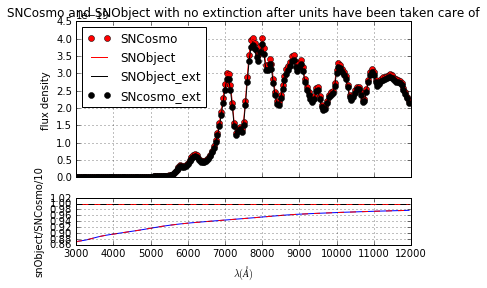

In [33]:

specfig, specax, diff =  settwopanel(setdifflimits=None)
specax.plot(wave, SN.flux(time=mjdobs, wave=wave),'ro', label='SNCosmo')
SN_blank.set_MWebv(0.)
sed = SN_blank.SNObjectSED(time=mjdobs, wavelen=wavenm)
specax.plot(wave, sed.flambda /10.,'r-', label='SNObject' )
sed_ext = SN.SNObjectSED(time=mjdobs, wavelen=wavenm)
specax.plot(wave, sed_ext.flambda /10.,'k-', label='SNObject_ext' )
sn = SN.equivalentSNCosmoModel()
specax.plot(wave, sn.flux(wave=wave, time=mjdobs),'ko', label='SNcosmo_ext' )
specax.set_ylabel('flux density')
specax.legend(loc='best')

diff.set_xlabel(r'$\lambda (\AA)$')
diff.set_ylabel('snObject/SNCosmo/10')
diff.plot (wave, sed.flambda/SN.flux(time=mjdobs, wave=wave)/10.,'-r' )
diff.plot (wave, sed_ext.flambda/sn.flux(time=mjdobs, wave=wave)/10.,'--k' )
diff.plot(wave, sed_ext.flambda / sed.flambda, '-b')
diff.plot(wave, sn.flux(wave=wave, time=mjdobs) / SN.flux(time=mjdobs,
                                                          wave=wave), '--r')


specax.set_title('SNCosmo and SNObject with no extinction after units have been taken care of')

In [34]:
print sn

source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 1.0
  phases     : [-20, .., 50] days
  wavelengths: [300, .., 18000] Angstroms
effect (name='host' frame='rest'):
  class           : OD94Dust
  wavelength range: [909.09, 33333.3] Angstroms
effect (name='mw' frame='obs'):
  class           : OD94Dust
  wavelength range: [909.09, 33333.3] Angstroms
parameters:
  z       = 0.95999999999999996
  t0      = 571181.0
  x0      = 1.796112e-06
  x1      = 2.6600000000000001
  c       = 0.35299999999999998
  hostebv = 0.0
  hostr_v = 3.1000000000000001
  mwebv   = 0.02711203508079052
  mwr_v   = 3.1000000000000001


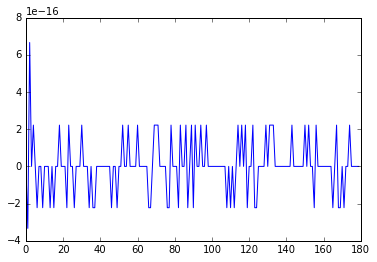

In [35]:
# Shows the difference between SNCosmo and SNObject SED flux Densities
plt.plot(SN.SNObjectSED(time=mjdobs, wavelen=wavenm).flambda / sn.flux(wave=wave, time=mjdobs) /10. -1.)

In [36]:
SN.rectifySED = True

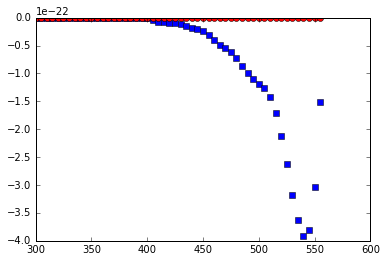

In [37]:
mask =sn.flux(wave=wave, time=mjdobs+10) < 0
plt.plot(wavenm[mask], sn.flux(wave=wave, time=mjdobs + 10)[mask] /10., 'bs')
plt.plot(wavenm[mask], SN.SNObjectSED(time=mjdobs + 10, wavelen=wavenm).flambda[mask], 'ro')
#plt.plot(wavenm[sn.flux(wave=wave, time=mjdobs+10) < 0], sn.flux(wave=wave, 
#                         time=mjdobs+10)[sn.flux(wave=wave, time=mjdobs+10) < 0] /10., 's')
#plt.plot(wavenm[mask], SN.SNObjectSED)
#plt.plot(wavenm[SN.SNObjectSED(wave=wave, time=mjdobs+10) < 0], sn.flux(wave=wave, 
#                         time=mjdobs+10)[sn.flux(wave=wave, time=mjdobs+10) < 0] /10., 's')
#plt.plot(wavenm, SN.SNObjectSED(time=mjdobs+10, wavelen=wavenm).flambda )
#plt.ylim(ymax=)

## Fluxes in BandPasses

In [38]:
wave = np.arange(10., 15000., 50.)
sed = SN.SNObjectSED(time=mjdobs, wavelen=wave)

/Users/rbiswas/src/LSST/sims_catUtils/python/lsst/sims/catUtils/supernovae/snObject.py:558: RuntimeWarning: invalid value encountered in greater
  flambda = np.where(flambda > 0., flambda, 0.)


In [39]:
sn = SN.equivalentSNCosmoModel()

In [40]:
from astropy.units import Unit
bp = sncosmo.Bandpass(wave=LSST_BandPass['r'].wavelen, 
                      trans=LSST_BandPass['r'].sb, 
                      wave_unit=Unit('nm'), name='lsst_r')

In [41]:
mjdobs

571190

In [42]:
SN.catsimBandFlux(bandpassobject=LSST_BandPass['r'], time=mjdobs)# , phiarray=pbase.phiArray)

2.0719475911259226e-11

In [43]:
sn.bandflux(time=mjdobs, band=bp, zp=0., zpsys='ab' )

2.0719475364610161e-11

In [44]:
SN.catsimBandMag(bandpassobject=LSST_BandPass['r'], time=mjdobs)

26.70905308512188

In [45]:
sn.bandmag(time=mjdobs, band=bp, magsys='ab' )

26.709053113767233

In [46]:
SN.catsimManyBandFluxes(time=mjdobs, bandpassDict=LSST_BandPass, observedBandPassInd=None)

array([  2.10319510e-15,   4.25170193e-13,   2.07194759e-11,
         1.39214069e-10,   1.98499836e-10,   2.09115003e-10])

In [47]:
SN.catsimManyBandMags(time=mjdobs, bandpassDict=LSST_BandPass, observedBandPassInd=None)

array([ 36.6928011 ,  30.92859298,  26.70905309,  24.64079218,
        24.25559962,  24.19903702])

##  Redshifting an Instance Of a Supernova

In [48]:
SN.SNstate

{'MWE(B-V)': 0.02711203508079052,
 'ModelSource': 'salt2-extended',
 '_dec': -1.0471975511965976,
 '_ra': 0.52359877559829882,
 'c': 0.35299999999999998,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 571181.0,
 'x0': 1.796112e-06,
 'x1': 2.6600000000000001,
 'z': 0.95999999999999996}

Note that while parameters of the model can be changed by using the set method, this assumes that other model parameters are kept constant. This is particularly important to remember if we want to 'move' a SN to a different redshift. For example if we take the above SN and change its redshift to z=0.3, using the set method, we do not change the 'x0' parameter because it is a different model parameter

In [49]:
SN.set(z=0.3)

In [50]:
print(SN.SNstate)

{'c': 0.35299999999999998, 'z': 0.29999999999999999, 'mwebv': 0.0, 'ModelSource': 'salt2-extended', '_dec': -1.0471975511965976, 't0': 571181.0, '_ra': 0.52359877559829882, 'hostebv': 0.0, 'mwr_v': 3.1000000000000001, 'x0': 1.796112e-06, 'x1': 2.6600000000000001, 'hostr_v': 3.1000000000000001, 'MWE(B-V)': 0.02711203508079052}


! No change is x0 value. However, this determines how bright the SN appears to be. Thus, this is a SN with dramatically different intrinsic properties, which may not be what was desired. For this purpose, we have a different convenience function redshift. Since this depends on the distance modulus, inputting the cosmology is important

In [51]:
from astropy.cosmology import FlatLambdaCDM

In [52]:
cosmo = FlatLambdaCDM(Om0=0.3, H0=70.)

In [53]:
SN.redshift(z=0.3, cosmo=cosmo)

In [54]:
SN.SNstate

{'MWE(B-V)': 0.02711203508079052,
 'ModelSource': 'salt2-extended',
 '_dec': -1.0471975511965976,
 '_ra': 0.52359877559829882,
 'c': 0.35299999999999998,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 571181.0,
 'x0': 1.8423737820256315e-06,
 'x1': 2.6600000000000001,
 'z': 0.29999999999999999}

Note that the SN redshift has changed appropriately !

In [55]:
SN.redshift(z=0.05, cosmo=cosmo)

In [56]:
print(SN.SNstate)

{'c': 0.35299999999999998, 'z': 0.050000000000000003, 'mwebv': 0.0, 'ModelSource': 'salt2-extended', '_dec': -1.0471975511965976, 't0': 571181.0, '_ra': 0.52359877559829882, 'hostebv': 0.0, 'mwr_v': 3.1000000000000001, 'x0': 9.2204035901324408e-05, 'x1': 2.6600000000000001, 'hostr_v': 3.1000000000000001, 'MWE(B-V)': 0.02711203508079052}
